In [1]:
import math 
from collections import Counter, defaultdict  
from functools import partial

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            classification_report, accuracy_score, \
                            recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler

plt.style.use("fivethirtyeight")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dfed = pd.read_csv("/content/drive/MyDrive/Project/ED Data in Brief/DATA.csv")

In [4]:
dfed

,p. no.,ECG Records,Spo2,H. Blood(mHg),L. Blood(mHg),Chest Pain,Shortness of Breath,Palpitation.,rest?,Peaks,QRS width,Peak to Peak,ST El.,OutputTriage level
0,1,Sleep Apnea Records,97,23,12,False,False,False,False,67,0.06,Regular,YES,Sick
1,2,Sleep Apnea Records,97,23,12,False,False,False,True,67,0.06,Regular,YES,Sick
2,3,Sleep Apnea Records,97,23,12,False,False,True,False,67,0.06,Regular,YES,Sick
3,4,Sleep Apnea Records,97,23,12,False,False,True,True,67,0.06,Regular,YES,Sick
4,5,Sleep Apnea Records,97,23,12,False,True,False,False,67,0.06,Regular,YES,Sick
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,576,Normal ECG with HR 110,92,12,8,False,False,False,True,110,NaN,Regular,UNKNOWN,Sick
576,577,Normal ECG with HR 110,92,12,8,False,False,False,True,110,NaN,Regular,UNKNOWN,Sick
577,578,Normal ECG with HR 110,92,12,8,False,False,False,True,110,NaN,Regular,UNKNOWN,Sick
578,579,Normal ECG with HR 110,92,12,8,False,False,False,True,110,NaN,Regular,UNKNOWN,Sick


In [5]:
dfed1=dfed[['Chest Pain','Shortness of Breath','Palpitation.','rest?']]
dfed1=dfed1.astype(str)
dfed[['Chest Pain','Shortness of Breath','Palpitation.','rest?']]=dfed1
dfed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   p. no.               580 non-null    int64  
 1   ECG Records          580 non-null    object 
 2   Spo2                 580 non-null    int64  
 3   H. Blood(mHg)        580 non-null    int64  
 4   L. Blood(mHg)        580 non-null    int64  
 5   Chest Pain           580 non-null    object 
 6   Shortness of Breath  580 non-null    object 
 7   Palpitation.         580 non-null    object 
 8   rest?                580 non-null    object 
 9   Peaks                580 non-null    object 
 10  QRS width            500 non-null    float64
 11  Peak to Peak         580 non-null    object 
 12  ST El.               580 non-null    object 
 13  OutputTriage level   580 non-null    object 
dtypes: float64(1), int64(4), object(9)
memory usage: 63.6+ KB


In [6]:
mean=dfed['QRS width'].mean()
dfed['QRS width'].fillna(mean,inplace=True)
del dfed['p. no.']
dfed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ECG Records          580 non-null    object 
 1   Spo2                 580 non-null    int64  
 2   H. Blood(mHg)        580 non-null    int64  
 3   L. Blood(mHg)        580 non-null    int64  
 4   Chest Pain           580 non-null    object 
 5   Shortness of Breath  580 non-null    object 
 6   Palpitation.         580 non-null    object 
 7   rest?                580 non-null    object 
 8   Peaks                580 non-null    object 
 9   QRS width            580 non-null    float64
 10  Peak to Peak         580 non-null    object 
 11  ST El.               580 non-null    object 
 12  OutputTriage level   580 non-null    object 
dtypes: float64(1), int64(3), object(9)
memory usage: 59.0+ KB


In [7]:
num=dfed.select_dtypes(include='number').columns.tolist()
cat=dfed.select_dtypes(include='object').columns.tolist()
print(num)
print(cat)

['Spo2', 'H. Blood(mHg)', 'L. Blood(mHg)', 'QRS width']
['ECG Records', 'Chest Pain', 'Shortness of Breath', 'Palpitation.', 'rest?', 'Peaks', 'Peak to Peak', 'ST El.', 'OutputTriage level']


In [8]:
dfed[num].describe().T

,count,mean,std,min,25%,50%,75%,max
Spo2,580.0,91.193103,6.785432,80.000,92.00,92.000,97.0000,97.0
H. Blood(mHg),580.0,16.386207,4.611596,12.000,12.00,15.000,23.0000,23.0
L. Blood(mHg),580.0,9.903448,1.634364,8.000,8.00,10.000,12.0000,12.0
QRS width,580.0,0.197800,0.182178,0.047,0.06,0.169,0.1978,0.5


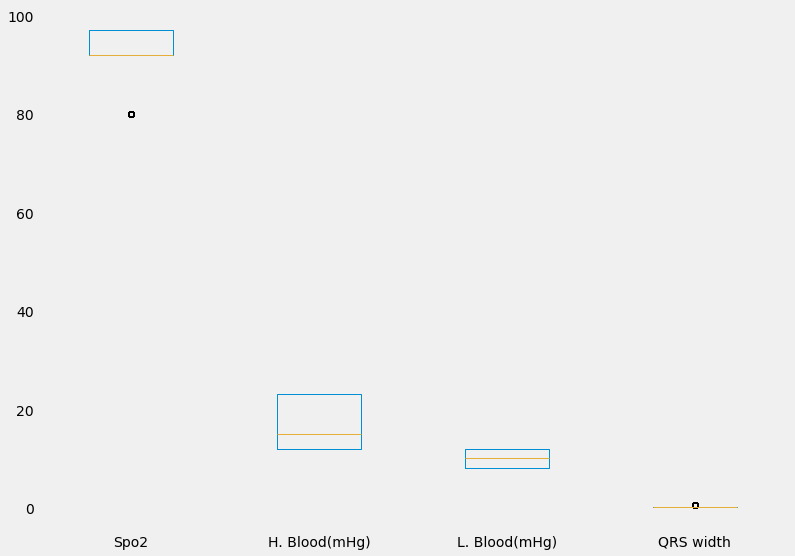

In [9]:
dfed[num].plot(kind='box',figsize=(12,9))
plt.grid(False)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  import sys


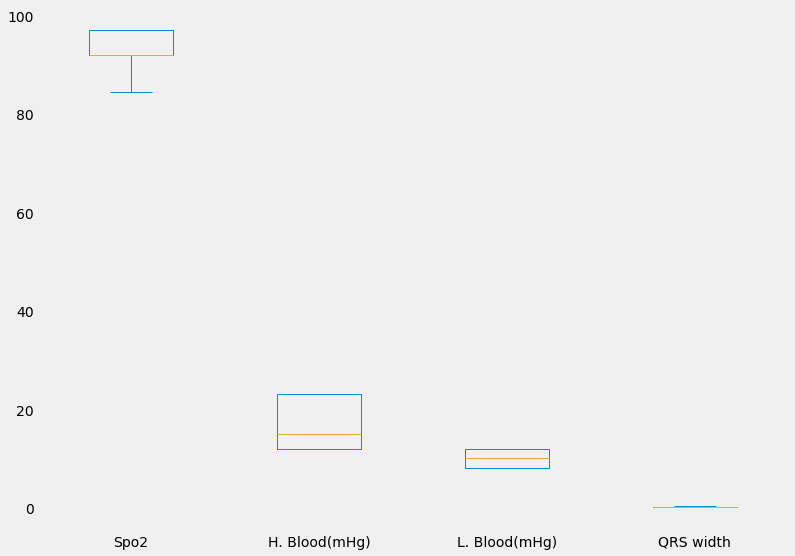

In [10]:
q1=dfed[['Spo2','QRS width']].quantile(0.25)
q3=dfed[['Spo2','QRS width']].quantile(0.75)
IQR=q3-q1
max=q3+1.5*IQR
min=q1-1.5*IQR
dfed=dfed.mask(dfed>max,max,axis=1)
dfed=dfed.mask(dfed<min,min,axis=1)
dfed[num].plot(kind='box',figsize=(12,9))
plt.grid(False)
plt.show()

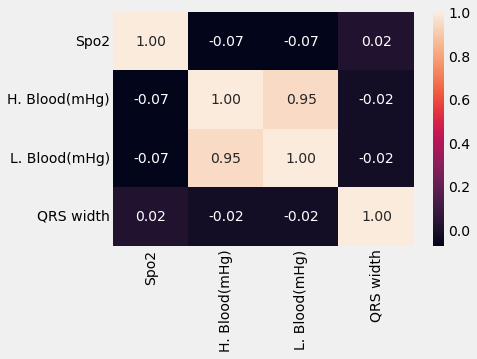

In [11]:
sns.heatmap(dfed[num].corr(),annot=True,fmt='.2f')
plt.show()

In [12]:
num=dfed.select_dtypes(include='number').columns.tolist()
cat=dfed.select_dtypes(include='object').columns.tolist()
print(num)
print(cat)

['Spo2', 'H. Blood(mHg)', 'L. Blood(mHg)', 'QRS width']
['ECG Records', 'Chest Pain', 'Shortness of Breath', 'Palpitation.', 'rest?', 'Peaks', 'Peak to Peak', 'ST El.', 'OutputTriage level']


In [13]:
dfed[cat].describe().T

,count,unique,top,freq
ECG Records,580,6,Arrythmia Records,288
Chest Pain,580,2,False,296
Shortness of Breath,580,2,False,300
Palpitation.,580,2,False,304
rest?,580,2,True,304
Peaks,580,6,67,144
Peak to Peak,580,1,Regular,580
ST El.,580,3,YES,288
OutputTriage level,580,5,Sick,291


In [14]:
x=dfed.drop(columns=['OutputTriage level']).copy()
y=dfed['OutputTriage level'].copy()

In [15]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=.2,stratify=y,random_state=11)

print(f'training size: {xtrain.shape[0]} ({100*xtrain.shape[0]/x.shape[0]:.2f}%)')
print(f'test size: {xtest.shape[0]} ({100*xtest.shape[0]/x.shape[0]:.2f}%)')

training size: 464 (80.00%)
test size: 116 (20.00%)


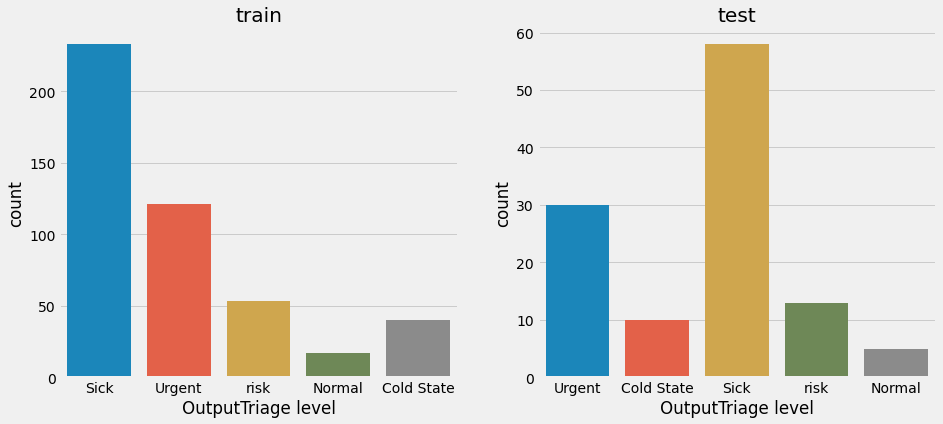

In [16]:
fig,axis=plt.subplots(1,2,figsize=(14,6))
for i,label in enumerate([(ytrain,'train'),(ytest,'test')]):
  sns.countplot(x=label[0],ax=axis[i])
  axis[i].set_title(label[1])
plt.show()

In [17]:
print("Before oversampling: ", Counter(ytrain))

Before oversampling:  Counter({'Sick': 233, 'Urgent': 121, 'risk': 53, 'Cold State': 40, 'Normal': 17})


In [18]:
oversample=RandomOverSampler(sampling_strategy='not majority')

In [19]:
xtrain_ov,ytrain_ov=oversample.fit_resample(xtrain,ytrain)

In [20]:
print("After oversampling: ", Counter(ytrain_ov))

After oversampling:  Counter({'Sick': 233, 'Urgent': 233, 'risk': 233, 'Normal': 233, 'Cold State': 233})


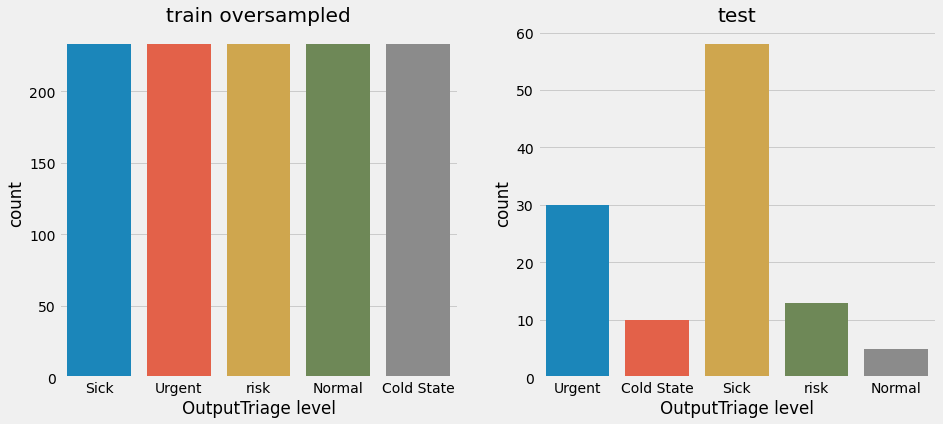

In [21]:
fig,axis=plt.subplots(1,2,figsize=(14,6))
for i,label in enumerate([(ytrain_ov,'train oversampled'),(ytest,'test')]):
  sns.countplot(x=label[0],ax=axis[i])
  axis[i].set_title(label[1])
plt.show()

In [22]:
nomfeat=['Chest Pain','Shortness of Breath','Palpitation.','rest?']
orfeat=x.select_dtypes(include='object').drop(columns=nomfeat).columns.tolist()
print(nomfeat)
print(orfeat)

['Chest Pain', 'Shortness of Breath', 'Palpitation.', 'rest?']
['ECG Records', 'Peaks', 'Peak to Peak', 'ST El.']


In [23]:
onehot=OneHotEncoder()
onehot.fit(xtrain_ov[nomfeat])
xtrain_oh=pd.DataFrame(onehot.transform(xtrain_ov[nomfeat]).toarray(),columns=onehot.get_feature_names_out())
xtest_oh=pd.DataFrame(onehot.transform(xtest[nomfeat]).toarray(),columns=onehot.get_feature_names_out())
display(xtrain_oh)

ordinal=OrdinalEncoder()
ordinal.fit(xtrain_ov[orfeat])
xtrain_or=pd.DataFrame(ordinal.transform(xtrain_ov[orfeat]),columns=ordinal.feature_names_in_)
xtest_or=pd.DataFrame(ordinal.transform(xtest[orfeat]),columns=ordinal.feature_names_in_)
display(xtrain_or)

,Chest Pain_False,Chest Pain_True,Shortness of Breath_False,Shortness of Breath_True,Palpitation._False,Palpitation._True,rest?_False,rest?_True
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
1160,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1161,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1162,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1163,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


,ECG Records,Peaks,Peak to Peak,ST El.
0,0.0,1.0,0.0,0.0
1,2.0,3.0,0.0,2.0
2,0.0,4.0,0.0,2.0
3,5.0,3.0,0.0,2.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
1160,5.0,3.0,0.0,2.0
1161,2.0,3.0,0.0,2.0
1162,5.0,3.0,0.0,2.0
1163,0.0,4.0,0.0,2.0


In [24]:
xtrain_comb=pd.concat([xtrain_ov[num].reset_index(drop=True),xtrain_oh,xtrain_or],axis=1)
xtest_comb=pd.concat([xtest[num].reset_index(drop=True),xtest_oh,xtest_or],axis=1)
xtrain_comb

,Spo2,H. Blood(mHg),L. Blood(mHg),QRS width,Chest Pain_False,Chest Pain_True,Shortness of Breath_False,Shortness of Breath_True,Palpitation._False,Palpitation._True,rest?_False,rest?_True,ECG Records,Peaks,Peak to Peak,ST El.
0,97.0,15,10,0.4045,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,84.5,23,12,0.0600,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,3.0,0.0,2.0
2,92.0,15,10,0.0470,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0,2.0
3,97.0,23,12,0.0600,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,5.0,3.0,0.0,2.0
4,84.5,23,12,0.4045,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,84.5,12,8,0.0600,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,5.0,3.0,0.0,2.0
1161,84.5,23,12,0.0600,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,3.0,0.0,2.0
1162,84.5,12,8,0.0600,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,5.0,3.0,0.0,2.0
1163,84.5,23,12,0.0470,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0,2.0


In [25]:
scaler=StandardScaler()
scaler.fit(xtrain_comb)

xtrain_scal=pd.DataFrame(scaler.transform(xtrain_comb),columns=xtrain_comb.columns)
xtest_scal=pd.DataFrame(scaler.transform(xtest_comb),columns=xtest_comb.columns)
xtrain_scal.head()

,Spo2,H. Blood(mHg),L. Blood(mHg),QRS width,Chest Pain_False,Chest Pain_True,Shortness of Breath_False,Shortness of Breath_True,Palpitation._False,Palpitation._True,rest?_False,rest?_True,ECG Records,Peaks,Peak to Peak,ST El.
0,0.779192,-0.127764,0.274213,1.897119,-1.046577,1.046577,0.838580,-0.838580,0.787595,-0.787595,-0.822350,0.822350,-1.045012,-0.908379,0.0,-1.450965
1,-1.721522,1.623353,1.470683,-0.888170,0.955496,-0.955496,-1.192492,1.192492,0.787595,-0.787595,-0.822350,0.822350,-0.004466,0.242531,0.0,1.042213
2,-0.221093,-0.127764,0.274213,-0.993276,-1.046577,1.046577,0.838580,-0.838580,0.787595,-0.787595,1.216028,-1.216028,-1.045012,0.817985,0.0,1.042213
3,0.779192,1.623353,1.470683,-0.888170,-1.046577,1.046577,0.838580,-0.838580,-1.269688,1.269688,-0.822350,0.822350,1.556353,0.242531,0.0,1.042213
4,-1.721522,1.623353,1.470683,1.897119,0.955496,-0.955496,-1.192492,1.192492,0.787595,-0.787595,1.216028,-1.216028,-1.045012,-0.908379,0.0,-1.450965


In [26]:
model=KNeighborsClassifier()

In [27]:
model.fit(xtrain_scal,ytrain_ov)

KNeighborsClassifier()

In [28]:
pred_train=model.predict(xtrain_scal)
pred_test=model.predict(xtest_scal)

In [29]:
print('Classification Report Train Data kNN')
print(classification_report(ytrain_ov,pred_train))
print('Classification Report Test Data kNN')
print(classification_report(ytest,pred_test))

Classification Report Train Data kNN
              precision    recall  f1-score   support

  Cold State       0.92      1.00      0.96       233
      Normal       1.00      1.00      1.00       233
        Sick       0.90      0.81      0.85       233
      Urgent       0.88      0.82      0.85       233
        risk       0.91      0.99      0.95       233

    accuracy                           0.92      1165
   macro avg       0.92      0.92      0.92      1165
weighted avg       0.92      0.92      0.92      1165

Classification Report Test Data kNN
              precision    recall  f1-score   support

  Cold State       0.40      0.60      0.48        10
      Normal       1.00      1.00      1.00         5
        Sick       0.87      0.67      0.76        58
      Urgent       0.61      0.63      0.62        30
        risk       0.55      0.85      0.67        13

    accuracy                           0.69       116
   macro avg       0.69      0.75      0.71       116
weig

Confusion Matrix Train Data kNN


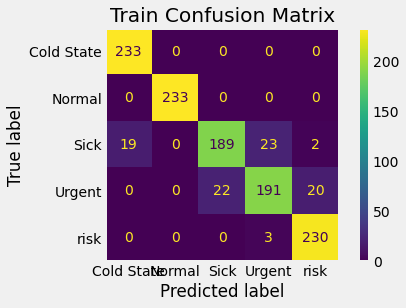

Confusion Matrix Test Data kNN


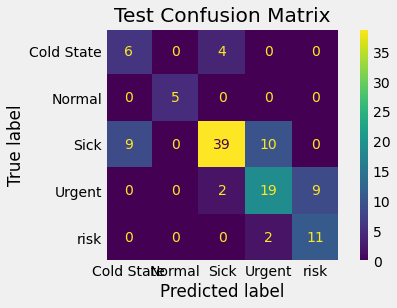

In [30]:
print('Confusion Matrix Train Data kNN')
ConfusionMatrixDisplay.from_predictions(ytrain_ov, pred_train)
plt.title("Train Confusion Matrix")
plt.grid(False)
plt.show()

print('Confusion Matrix Test Data kNN')
ConfusionMatrixDisplay.from_predictions(ytest, pred_test)
plt.title("Test Confusion Matrix")
plt.grid(False)
plt.show()